In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from autograd import grad
import autograd.numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [2]:
class Scheduler:
    """
    class for Schedulers
    """

    def __init__(self, eta):
        self.eta = eta

    # should be overwritten
    def update_change(self, gradient):
        raise NotImplementedError

    # overwritten if needed
    def reset(self):
        pass


class Constant(Scheduler):
    def __init__(self, eta):
        super().__init__(eta)

    def update_change(self, gradient):
        return self.eta * gradient
    
    def reset(self):
        pass


class Momentum(Scheduler):
    def __init__(self, eta: float, momentum: float):
        super().__init__(eta)
        self.momentum = momentum
        self.change = 0

    def update_change(self, gradient):
        self.change = self.momentum * self.change + self.eta * gradient
        return self.change

    def reset(self):
        pass


class Adagrad(Scheduler):
    def __init__(self, eta):
        super().__init__(eta)
        self.G_t = None

    def update_change(self, gradient):
        delta = 1e-8  # avoid division ny zero

        if self.G_t is None:
            self.G_t = np.zeros((gradient.shape[0], gradient.shape[0]))

        self.G_t += gradient @ gradient.T

        G_t_inverse = 1 / (
            delta + np.sqrt(np.reshape(np.diagonal(self.G_t), (self.G_t.shape[0], 1)))
        )
        return self.eta * gradient * G_t_inverse

    def reset(self):
        self.G_t = None


class AdagradMomentum(Scheduler):
    def __init__(self, eta, momentum):
        super().__init__(eta)
        self.G_t = None
        self.momentum = momentum
        self.change = 0

    def update_change(self, gradient):
        delta = 1e-8  # avoid division ny zero

        if self.G_t is None:
            self.G_t = np.zeros((gradient.shape[0], gradient.shape[0]))

        self.G_t += gradient @ gradient.T

        G_t_inverse = 1 / (
            delta + np.sqrt(np.reshape(np.diagonal(self.G_t), (self.G_t.shape[0], 1)))
        )
        self.change = self.change * self.momentum + self.eta * gradient * G_t_inverse
        return self.change

    def reset(self):
        self.G_t = None


class RMS_prop(Scheduler):
    def __init__(self, eta, rho):
        super().__init__(eta)
        self.rho = rho
        self.second = 0.0

    def update_change(self, gradient):
        delta = 1e-8  # avoid division ny zero
        self.second = self.rho * self.second + (1 - self.rho) * gradient * gradient
        return self.eta * gradient / (np.sqrt(self.second + delta))

    def reset(self):
        self.second = 0.0


class Adam(Scheduler):
    def __init__(self, eta, rho, rho2):
        super().__init__(eta)
        self.rho = rho
        self.rho2 = rho2
        self.moment = 0
        self.second = 0
        self.n_epochs = 1

    def update_change(self, gradient):
        delta = 1e-8  # avoid division ny zero

        self.moment = self.rho * self.moment + (1 - self.rho) * gradient
        self.second = self.rho2 * self.second + (1 - self.rho2) * gradient * gradient

        moment_corrected = self.moment / (1 - self.rho**self.n_epochs)
        second_corrected = self.second / (1 - self.rho2**self.n_epochs)

        return self.eta * moment_corrected / (np.sqrt(second_corrected + delta))

    def reset(self):
        self.n_epochs += 1
        self.moment = 0
        self.second = 0

In [3]:
def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

In [4]:
####referere til designMatrix####

def designMatrix(x, y, deg):
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)

    N = len(x)
    l = int((deg+1)*(deg+2)/2) 
    X = np.ones((N,l))

    for i in range(1,deg+1):
        q = int((i)*(i+1)/2)
        for k in range(i+1):
            X[:,q+k] = (x**(i-k))*(y**k)
        
    return X[:, 1:] #removes intercept

#Scaling function for the design matrix. obtains mean= 0 and variance=1
def scale(X_train,X_test,y_train,y_test):
    x_scaler = StandardScaler(with_std=False).fit(X_train)
    X_train = x_scaler.transform(X_train)
    X_test = x_scaler.transform(X_test)
    y_scaler = StandardScaler(with_std=False).fit(y_train.reshape(-1,1))
    y_train = y_scaler.transform(y_train.reshape(-1,1)).ravel()
    y_test = y_scaler.transform(y_test.reshape(-1,1)).ravel()
    return X_train, X_test,y_train, y_test



In [22]:
 def GD_ols(X,y,eta=0.1,Niterations=1000, convergence_criteria=10**(-8)):
        np.random.seed(123)
        n_samples, n_features = X.shape
        theta = np.random.randn(n_features) # Picking out initial beta values. 
        iteration = 0 #initial
        gradient_n = 0 #initial
        converge_rate = 20 #chosen initial value
        for i in range(Niterations):
            gradients = (2/n_samples) * X.T @ (X @ theta - y) 
            convergence_rate = np.linalg.norm(np.absolute(gradients-gradient_n))
            gradient_n = gradients
            theta = theta - eta*gradients
            if (converge_rate < convergence_criteria):
                iteration = i
                print(f"Converged at iteration format.{i}.")
                break
        theta_gd = theta
        iteration = i
        return theta_gd,iteration

In [6]:
# Create data
np.random.seed(40)
n = 40     # n x n = number of datapoints
sigma2 = 0.01   # variance
sigma = np.sqrt(sigma2) #standard deviation

x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)
noise = np.random.normal(0, sigma, int(n*n))
                         
# Create mesh and unravel
x, y = np.meshgrid(x, y)
x = np.ravel(x)
y = np.ravel(y)
z = FrankeFunction(x, y) + noise

X = designMatrix(x, y, 11)
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2,random_state=11)
X_train, X_test, z_train, z_test = scale(X_train, X_test, z_train, z_test)

In [7]:
maxdeg = 11
degrees=np.arange(1,maxdeg+1)
Niterations = 100000 #1 000 000 is better, but takes forever
convergence = 1e-8

In [8]:
def learning_schedule(eta,decay,epoch):
    return (eta/(1+decay*epoch))

def Cost_func_ols(y,X,theta):
    return np.sum((y-X @ theta)**2)

grad_ols = grad(Cost_func_ols,2) 

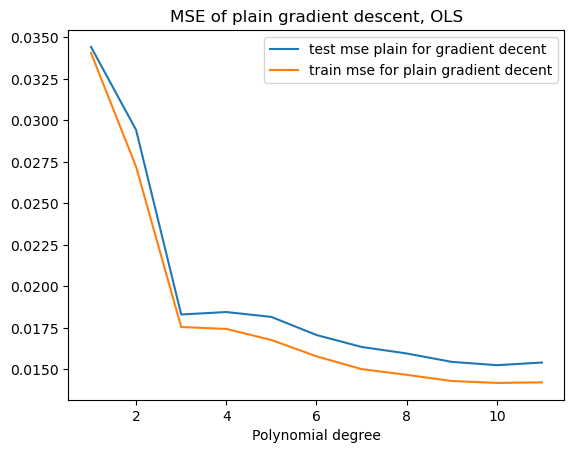

In [9]:
mse_gd_itter = []
mse_gd_poly = []
mse_gd_poly_train = []
theta = []
theta_i = 0
np.random.seed(40)
#plotting MSE against degree to check which degree we can use and to ensure the GD code is working properly. 
for i,deg in enumerate(degrees):
    X = designMatrix(x, y, deg)
    n_samples, n_features = X.shape
    z = FrankeFunction(x, y) + noise
    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2,random_state=11)
    X_train, X_test, z_train, z_test = scale(X_train, X_test, z_train, z_test) #Normalizes the data
    eta = 0.1 #uses a fixed learning rate
    theta_i,itter_n = GD_ols(X_train,z_train,eta,Niterations,convergence)

    theta.append(theta_i)
    z_pred = X_test @ theta_i
    z_tilde = X_train @ theta_i
    
    mse_gd_poly.append(mean_squared_error(z_test,z_pred))
    mse_gd_poly_train.append(mean_squared_error(z_train,z_tilde))
   
plt.plot(degrees, mse_gd_poly, label='test mse plain for gradient decent')
plt.plot(degrees, mse_gd_poly_train, label='train mse for plain gradient decent')
plt.legend()
plt.xlabel("Polynomial degree")
#plt.ylabel("MSE")
plt.title("MSE of plain gradient descent, OLS")
plt.show()
#with lambda=0.001 the OLS is better. Expected since we have no noise? takes forever to run.

#Eta=0.1, scaling=yes, degree=8, MSE= ~0.0150. good shape
#Eta=0.01, scaling=yes, degree=8, MSE=~

In [10]:
def minibatch_creator(X, y, batch_size):
        np.random.seed(321)
        minibatches = []
        data_matrix = np.hstack((X, y.reshape(-1, 1))) 
        np.random.shuffle(data_matrix) 
        m = data_matrix.shape[0] // batch_size 
        i=0
        for i in range(m):
            minibatch = data_matrix[i * batch_size:(i + 1)*batch_size, :]
            X_minibatch = minibatch[:, :-1] 
            Y_minibatch = minibatch[:, -1] 
            minibatches.append((X_minibatch, Y_minibatch)) 
        if data_matrix.shape[0] % batch_size != 0:
            minibatch = data_matrix[i * batch_size:data_matrix.shape[0]]
            X_minibatch = minibatch[:, :-1]
            Y_minibatch = minibatch[:, -1]
            minibatches.append((X_minibatch, Y_minibatch))
        return minibatches

In [11]:
def learning_schedule(eta,decay,epoch):
    return (eta/(1+decay*epoch))

class SGD:
    def __init__(self, eta=0.1, epochs=100, minibatch_size=64, schedule = str(),momentum=0.9, rho = 0.9, rho2 = 0.999 ,decay = float()):
        """
        Stochastic Gradient Descent with different optimization schedules.

        Parameters:
        - eta: Initial learning rate.
        - epochs: Number of training epochs.
        - minibatch_size: Size of minibatches used in training.
        - schedule: Optimization schedule ('Mom', 'Rms', 'Adam', 'Adagrad', 'Adagradmom', or default 'Constant').
        - momentum: Momentum parameter for 'Mom' and 'Adagradmom' schedules.
        - rho: Rho parameter for 'Rms' and 'Adam' schedules.
        - rho2: Rho2 parameter for 'Adam' schedule.
        - decay: Decay factor for the learning rate schedule.
        
        """
        self.epochs = epochs
        self.minibatch_size = minibatch_size
        self.theta = None
        self.decay = decay
        self.eta = eta
        self.learning_rate = learning_schedule(self.eta,self.decay,self.epochs)
        if schedule == 'Mom':
            self.momentum = momentum
            self.schedule = Momentum(self.learning_rate, self.momentum)
            
        elif schedule == 'Rms':
            self.rho = rho
            self.schedule = RMS_prop(self.learning_rate, self.rho)
            
        elif schedule == 'Adam':
            self.rho = rho
            self.rho2 = rho2
            self.schedule = Adam(self.learning_rate,rho,rho2)
            
        elif schedule == 'Adagrad':
            self.schedule = Adagrad(self.learning_rate)
        
        elif schedule == 'Adagradmom':
            self.momentum = momentum
            self.schedule = AdagradMomentum(self.learning_rate, self.momentum)
        
        else:
            self.schedule = Constant(self.learning_rate)      
         
            
    def fit(self, X, y):
        """
        Fit the model using Stochastic Gradient Descent.

        Parameters:
        - X: Input features.
        - y: Target values.

        Returns:
        - Model parameters.
        - Learning rate.
        
        """
        # Initialize parameters and velocities
        n_samples, n_features   = X.shape
        self.theta = np.random.randn(n_features,1)
        change = np.random.randn(n_features,1)
        for epoch in range(self.epochs):
            minibatches = minibatch_creator(X,y,self.minibatch_size)
            for batch in minibatches:
                X_batch,y_batch = batch
                y_batch = y_batch.reshape(-1,1) # need a column vector
                gradients = (2/self.minibatch_size) * X_batch.T @ (X_batch @self.theta - y_batch)
                change = self.schedule.update_change(gradients)
                self.theta = self.theta - change
                self.schedule.reset()
        lr = self.eta
        return self.theta, lr


    #to compare automatic differentiation and analytical gradient computation
    def fit_autograd(self, X, y):
        n_samples, n_features   = X.shape
        self.theta = np.random.randn(n_features,1)
        change = np.random.randn(n_features,1)
        for epoch in range(self.epochs):
            minibatches = minibatch_creator(X,y,self.minibatch_size)
            for batch in minibatches:
                X_batch,y_batch = batch
                y_batch = y_batch.reshape(-1,1) # need a column vector
                gradients = (1/batch_size)*grad_ols(y_batch,X_batch,self.theta)
                change = self.schedule.update_change(gradients)
                self.theta = self.theta - change
                self.schedule.reset()
        lr = self.eta
        return self.theta, lr
    
    def predict(self, X):
        
        """
        Make predictions using the trained model.

        Parameters:
        - X: Input features.

        Returns:
        - Model predictions.
        """
    
        return X @ self.theta

In [12]:
gammas = np.arange(0.2,0.95,0.05)
decays = np.logspace(-6,-1,6)
n_epochs_array = np.arange(100,1000,100)
batch_size = 64
n_epochs = 1000

numberOfEtas=6
etas = np.logspace(-7,-1,numberOfEtas + 1)

## Checking the MSE of SGD with the constant learning rate 0.1, 0.01, 0.001 and 0.0001 as a function of number of epochs.
Not used in report 

In [13]:
eta_list = []
mse_eta_test = np.zeros((len(etas)))
mse_eta_train = np.zeros((len(etas)))

x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)
noise = np.random.normal(0, sigma, int(n*n))
                         
# Create mesh and unravel
x, y = np.meshgrid(x, y)
x = np.ravel(x)
y = np.ravel(y)

z = FrankeFunction(x, y) + noise

X = designMatrix(x, y, 8)

X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2,random_state=11)
X_train, X_test, z_train, z_test = scale(X_train, X_test, z_train, z_test)

n_samples, n_features = X.shape
n_epochs_array = np.arange(20,400,1)

mse_test_01 = np.zeros(len(n_epochs_array))
mse_test_001 = np.zeros(len(n_epochs_array))
mse_test_0001 = np.zeros(len(n_epochs_array))
mse_test_00001 = np.zeros(len(n_epochs_array))

theta_j = 0
lr = 0

for i,n_epochs in enumerate(n_epochs_array+1):
    #print(i,n_epochs)
    sgd_01 = SGD(epochs = n_epochs, eta=0.1, decay=1e-4, schedule="Constant")
    theta_j, lr = sgd_01.fit(X_train, z_train)
    #print(theta_j)
    z_tilde= X_test @ theta_j
    mse_test_01[i] = mean_squared_error(z_test,z_tilde)
        
    sgd_001 = SGD(epochs = n_epochs, eta=0.01 ,decay=1e-4, schedule="Constant")
    theta_j, lr = sgd_001.fit(X_train, z_train)
    z_tilde= X_test @ theta_j
    mse_test_001[i] = mean_squared_error(z_test,z_tilde)
        
    sgd_0001 = SGD(epochs = n_epochs, eta=0.001,decay=1e-4, schedule="Constant")
    theta_j, lr = sgd_0001.fit(X_train, z_train)
    z_tilde= X_test @ theta_j
    mse_test_0001[i] = mean_squared_error(z_test,z_tilde)
        
    sgd_00001 = SGD(epochs = n_epochs,eta=0.0001 ,decay=1e-4, schedule="Constant")
    theta_j, lr = sgd_00001.fit(X_train, z_train)
    z_tilde= X_test @ theta_j
    mse_test_00001[i] = mean_squared_error(z_test,z_tilde)

df_eta = pd.DataFrame(
    {'$\eta$=0.1': mse_test_01,
     '$\eta$=0.01': mse_test_001,
     '$\eta$=0.001': mse_test_0001,
     '$\eta$=0.0001': mse_test_00001})

## Same calculations as above, only using automatic differentiation with autograd
not used in report

In [14]:
eta_list = []
mse_eta_test = np.zeros((len(etas)))
mse_eta_train = np.zeros((len(etas)))

x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)
noise = np.random.normal(0, sigma, int(n*n))
                         
# Create mesh and unravel
x, y = np.meshgrid(x, y)
x = np.ravel(x)
y = np.ravel(y)

z = FrankeFunction(x, y) + noise

X = designMatrix(x, y, 8)

X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2,random_state=11)
X_train, X_test, z_train, z_test = scale(X_train, X_test, z_train, z_test)

n_samples, n_features = X.shape
n_epochs_array = np.arange(20,400,1)

mse_test_01 = np.zeros(len(n_epochs_array))
mse_test_001 = np.zeros(len(n_epochs_array))
mse_test_0001 = np.zeros(len(n_epochs_array))
mse_test_00001 = np.zeros(len(n_epochs_array))

theta_j = 0
lr = 0

for i,n_epochs in enumerate(n_epochs_array+1):
    #print(i,n_epochs)
    sgd_01 = SGD(epochs = n_epochs, eta=0.1, decay=1e-4, schedule="Constant")
    theta_j, lr = sgd_01.fit_autograd(X_train, z_train)
    #print(theta_j)
    z_tilde= X_test @ theta_j
    mse_test_01[i] = mean_squared_error(z_test,z_tilde)
        
    sgd_001 = SGD(epochs = n_epochs, eta=0.01 ,decay=1e-4, schedule="Constant")
    theta_j, lr = sgd_001.fit_autograd(X_train, z_train)
    z_tilde= X_test @ theta_j
    mse_test_001[i] = mean_squared_error(z_test,z_tilde)
        
    sgd_0001 = SGD(epochs = n_epochs, eta=0.001,decay=1e-4, schedule="Constant")
    theta_j, lr = sgd_0001.fit_autograd(X_train, z_train)
    z_tilde= X_test @ theta_j
    mse_test_0001[i] = mean_squared_error(z_test,z_tilde)
        
    sgd_00001 = SGD(epochs = n_epochs,eta=0.0001 ,decay=1e-4, schedule="Constant")
    theta_j, lr = sgd_00001.fit_autograd(X_train, z_train)
    z_tilde= X_test @ theta_j
    mse_test_00001[i] = mean_squared_error(z_test,z_tilde)

df_eta_ag = pd.DataFrame(
    {'$\eta$=0.1': mse_test_01,
     '$\eta$=0.01': mse_test_001,
     '$\eta$=0.001': mse_test_0001,
     '$\eta$=0.0001': mse_test_00001})

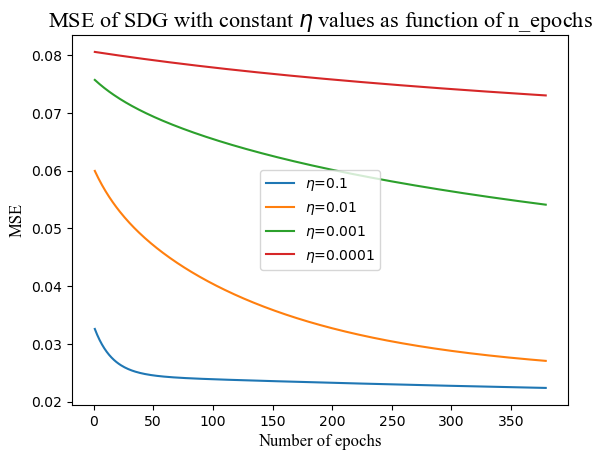

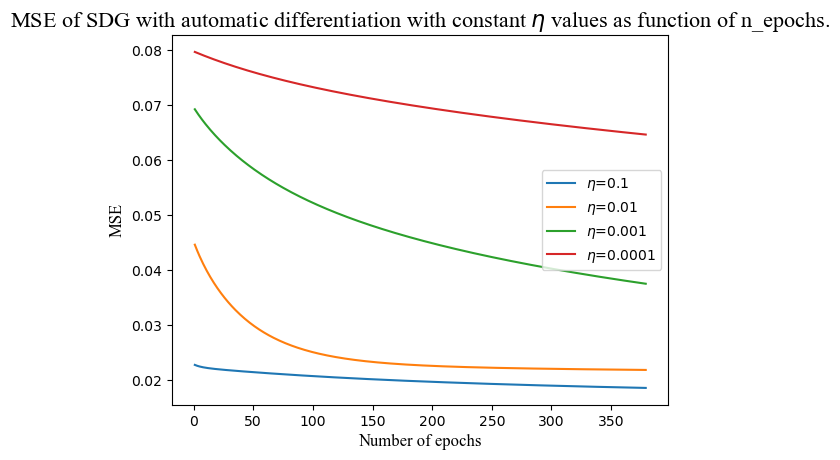

     $\eta$=0.1  $\eta$=0.01  $\eta$=0.001  $\eta$=0.0001
370    0.022407     0.027211      0.054354       0.073156
371    0.022402     0.027193      0.054327       0.073142
372    0.022398     0.027175      0.054300       0.073129
373    0.022394     0.027158      0.054273       0.073116
374    0.022389     0.027140      0.054247       0.073103
375    0.022385     0.027123      0.054220       0.073090
376    0.022381     0.027106      0.054193       0.073077
377    0.022376     0.027088      0.054166       0.073064
378    0.022372     0.027071      0.054140       0.073051
379    0.022368     0.027054      0.054113       0.073038
     $\eta$=0.1  $\eta$=0.01  $\eta$=0.001  $\eta$=0.0001
370    0.018621     0.021866      0.037790       0.064806
371    0.018617     0.021864      0.037758       0.064783
372    0.018612     0.021862      0.037726       0.064761
373    0.018607     0.021860      0.037695       0.064739
374    0.018603     0.021857      0.037663       0.064716
375    0.01859

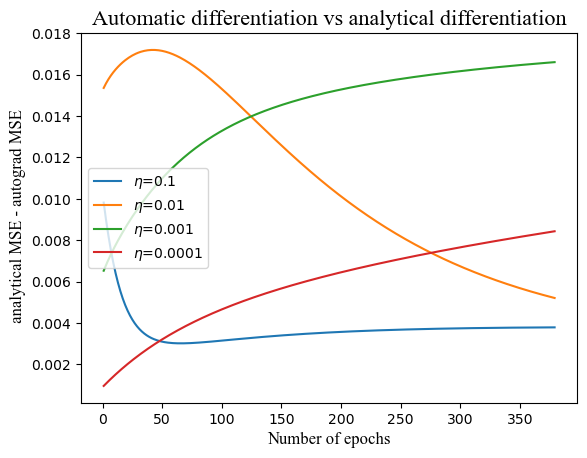

In [35]:
ax = df_eta[1:].plot()
ax.set_title("MSE of SDG with constant $\eta$ values as function of n_epochs", fontdict={'fontfamily': 'Times new roman'}, fontsize=16)
ax.set_xlabel("Number of epochs", fontdict={'fontfamily': 'Times New Roman'}, fontsize=12)
ax.set_ylabel("MSE", fontdict={'fontfamily': 'Times New Roman'}, fontsize=12)
plt.savefig("OLS_SDG_constant_Etas.png")
plt.show()
#print(df_eta[0:10])
#print(df_eta[100:110])

ax_ag = df_eta_ag[1:].plot()
ax_ag.set_title("MSE of SDG with automatic differentiation with constant $\eta$ values as function of n_epochs.", fontdict={'fontfamily': 'Times new roman'}, fontsize=16)
ax_ag.set_xlabel("Number of epochs", fontdict={'fontfamily': 'Times New Roman'}, fontsize=12)
ax_ag.set_ylabel("MSE", fontdict={'fontfamily': 'Times New Roman'}, fontsize=12)
plt.savefig("OLS_SDG_constant_Etas_autodiff.png")
plt.show()
print(df_eta[370:])
print(df_eta_ag[370:])

#difference in MSE between automatic differentiation and analytical differentiation with chain rule
diff=df_eta-df_eta_ag
ax_diff = diff[1:].plot()
ax_diff.set_title("Automatic differentiation vs analytical differentiation", fontdict={'fontfamily': 'Times new roman'}, fontsize=16)
ax_diff.set_xlabel("Number of epochs", fontdict={'fontfamily': 'Times New Roman'}, fontsize=12)
ax_diff.set_ylabel(" analytical MSE - autograd MSE", fontdict={'fontfamily': 'Times New Roman'}, fontsize=12)
plt.savefig("OLS_SDG_constant_Etas_diff.png")
plt.show()

It seems that for a small number of epochs, automatic differentiation gives a better MSE than analytic differentiation using the chain rule. For eta=0.1 and eta=0.01, the difference between autograd and analytical differentiation decreases with higher number of epochs, while the opposite is seen for eta=0.001 and eta=0.0001. Since eta=0.1 seems to provide the best results and the difference is "negligible" for a high number of epochs, we will continue using the analytical gradient together with a high number of epochs and eta of 0.1.

# Checking eta tuning algorithms.
Not used in report. The ridge one is used. 

NB! restart the kernel before running

In [16]:
n_epochs_array = np.arange(20,400,1)
#eta=0.1

mse_test_mom = np.zeros(len(n_epochs_array))
mse_test_adg = np.zeros(len(n_epochs_array))
mse_test_adgmom = np.zeros(len(n_epochs_array))
mse_test_rms = np.zeros(len(n_epochs_array))
mse_test_adam = np.zeros(len(n_epochs_array))
mse_test_const = np.zeros(len(n_epochs_array))

theta_j = 0
lr = 0
x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)
noise = np.random.normal(0, sigma, int(n*n))
                         
# Create mesh and unravel
x, y = np.meshgrid(x, y)
x = np.ravel(x)
y = np.ravel(y)

z = FrankeFunction(x, y) + noise

X = designMatrix(x, y, 8)

X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2,random_state=11)
X_train, X_test, z_train, z_test = scale(X_train, X_test, z_train, z_test)

for i,n_epochs in enumerate(n_epochs_array+1):
    sgd_const = SGD(epochs = n_epochs, minibatch_size = batch_size,eta=0.01, decay=1e-4, schedule = 'Constant')
    theta_j, lr = sgd_const.fit(X_train, z_train)
    z_tilde= X_test @ theta_j
    mse_test_const[i] = mean_squared_error(z_test,z_tilde)
    
    sgd_mom = SGD(epochs = n_epochs, minibatch_size = batch_size,eta=0.01, decay=1e-4, schedule = 'Mom')
    theta_j, lr = sgd_mom.fit(X_train, z_train)
    z_tilde= X_test @ theta_j
    mse_test_mom[i] = mean_squared_error(z_test,z_tilde)
        
    sgd_adg = SGD(epochs = n_epochs, minibatch_size = batch_size,eta=0.01 ,decay=1e-4, schedule = 'Adagrad')
    theta_j, lr = sgd_adg.fit(X_train, z_train)
    z_tilde= X_test @ theta_j
    mse_test_adg[i] = mean_squared_error(z_test,z_tilde)
        
    sgd_adgmom = SGD(epochs = n_epochs, minibatch_size = batch_size,eta=0.01 ,decay=1e-4, schedule = 'Adagradmom')
    theta_j, lr = sgd_adgmom.fit(X_train, z_train)
    z_tilde= X_test @ theta_j
    mse_test_adgmom[i] = mean_squared_error(z_test,z_tilde)
        
    sgd_adam = SGD(epochs = n_epochs, minibatch_size = batch_size,eta=0.01 ,decay=1e-4, schedule = 'Adam')
    theta_j, lr = sgd_adam.fit(X_train, z_train)
    z_tilde= X_test @ theta_j
    mse_test_adam[i] = mean_squared_error(z_test,z_tilde)
        
    sgd_rms = SGD(epochs = n_epochs, minibatch_size = batch_size,eta=0.01 ,decay=1e-4, schedule = 'Rms')
    theta_j, lr = sgd_rms.fit(X_train, z_train)
    z_tilde= X_test @ theta_j
    mse_test_rms[i] = mean_squared_error(z_test,z_tilde)


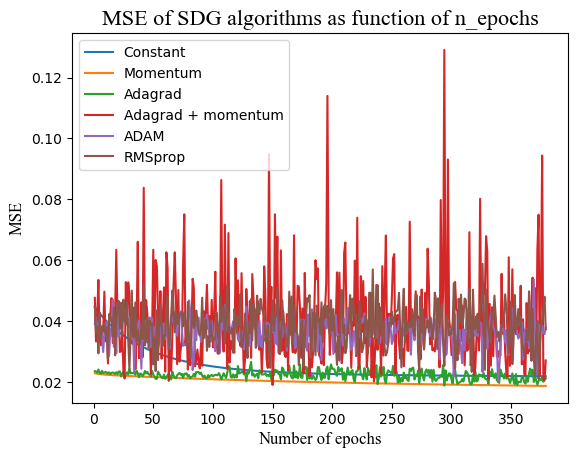

    Constant  Momentum   Adagrad  Adagrad + momentum      ADAM   RMSprop
40  0.031707  0.021742  0.022641            0.046127  0.024326  0.038252
41  0.031512  0.021725  0.021875            0.028120  0.037431  0.034071
42  0.031322  0.021709  0.022393            0.083769  0.033645  0.052185
43  0.031136  0.021692  0.023589            0.036200  0.040064  0.032058
44  0.030954  0.021676  0.022778            0.046845  0.039452  0.034463
45  0.030776  0.021659  0.023274            0.042586  0.032948  0.041000
46  0.030601  0.021643  0.022512            0.033019  0.036647  0.031210
47  0.030431  0.021627  0.022465            0.038392  0.041185  0.040105
48  0.030264  0.021610  0.021753            0.022572  0.031419  0.038806
49  0.030101  0.021594  0.023630            0.035865  0.040957  0.039277
50  0.029941  0.021578  0.022361            0.063401  0.034992  0.025734
51  0.029785  0.021562  0.021788            0.034517  0.037893  0.034381
52  0.029632  0.021547  0.021002            0.06004

In [17]:
df_algs = pd.DataFrame(
    {'Constant': mse_test_const,
     'Momentum': mse_test_mom,
     'Adagrad': mse_test_adg,
     'Adagrad + momentum': mse_test_adgmom,
     'ADAM': mse_test_adam,
     'RMSprop': mse_test_rms})

ax = df_algs[1:].plot()
ax.set_title("MSE of SDG algorithms as function of n_epochs", fontname="Times New Roman", fontsize=16)
ax.set_xlabel("Number of epochs", fontdict={'fontfamily': 'Times New Roman'}, fontsize=12)
ax.set_ylabel("MSE", fontdict={'fontfamily': 'Times New Roman'}, fontsize=12)
plt.savefig("OLS_SDG_eta_n_epochs_scaled.png")
plt.show()

print(df_algs[40:60])
print(df_algs[350:490])

Something happened to this code before delivering. It doesnt seem to converge anymore. However, a earlier sample is used in the report.

# Testing implication of batch size. $\eta = 0.1$ 

In [18]:
n_epochs_array = np.arange(100,1000,100) #increase step size to reduce running time
batch_sizes = np.array([10,20,50,100,200,500,len(X_train)])

mse_test_const = np.zeros((len(batch_sizes),len(n_epochs_array)))
mse_test_mom = np.zeros((len(batch_sizes),len(n_epochs_array)))
mse_test_adg = np.zeros((len(batch_sizes),len(n_epochs_array)))
mse_test_adgmom = np.zeros((len(batch_sizes),len(n_epochs_array)))
mse_test_rms = np.zeros((len(batch_sizes),len(n_epochs_array)))
mse_test_adam = np.zeros((len(batch_sizes),len(n_epochs_array)))

theta_j = 0
lr = 0
for i,batch_size in enumerate(batch_sizes):
    for j,n_epochs in enumerate(n_epochs_array):
        
        sgd_const = SGD(epochs = n_epochs, minibatch_size = batch_size, momentum = 0.9,  decay=1e-4, schedule = 'Constant')
        theta_j, lr = sgd_const.fit(X_train, z_train)
        z_tilde= X_test @ theta_j
        mse_test_const[i,j] = mean_squared_error(z_test,z_tilde)
        
        sgd_mom = SGD(epochs = n_epochs, minibatch_size = batch_size, momentum = 0.9,  decay=1e-4, schedule = 'Mom')
        theta_j, lr = sgd_mom.fit(X_train, z_train)
        z_tilde= X_test @ theta_j
        mse_test_mom[i,j] = mean_squared_error(z_test,z_tilde)
        
        sgd_adg = SGD(epochs = n_epochs, minibatch_size = batch_size, momentum = 0.9, decay=1e-4, schedule = 'Adagrad')
        theta_j, lr = sgd_adg.fit(X_train, z_train)
        z_tilde= X_test @ theta_j
        mse_test_adg[i,j] = mean_squared_error(z_test,z_tilde)
        
        sgd_adgmom = SGD(epochs = n_epochs, minibatch_size = batch_size, momentum = 0.9, decay=1e-4, schedule = 'Adagradmom')
        theta_j, lr = sgd_adgmom.fit(X_train, z_train)
        z_tilde= X_test @ theta_j
        mse_test_adgmom[i,j] = mean_squared_error(z_test,z_tilde)
        
        sgd_adam = SGD(epochs = n_epochs, minibatch_size = batch_size, momentum = 0.9, decay=1e-4, schedule = 'Adam')
        theta_j, lr = sgd_adam.fit(X_train, z_train)
        z_tilde= X_test @ theta_j
        mse_test_adam[i,j] = mean_squared_error(z_test,z_tilde)
        
        sgd_rms = SGD(epochs = n_epochs, minibatch_size = batch_size, momentum = 0.9, decay=1e-4, schedule = 'Rms')
        theta_j, lr = sgd_rms.fit(X_train, z_train)
        z_tilde= X_test @ theta_j
        mse_test_rms[i,j] = mean_squared_error(z_test,z_tilde)
        
formatted_batch_sizes = ["{:.2g}".format(i) for i in batch_sizes]



AttributeError: 'Axes' object has no attribute 'show'

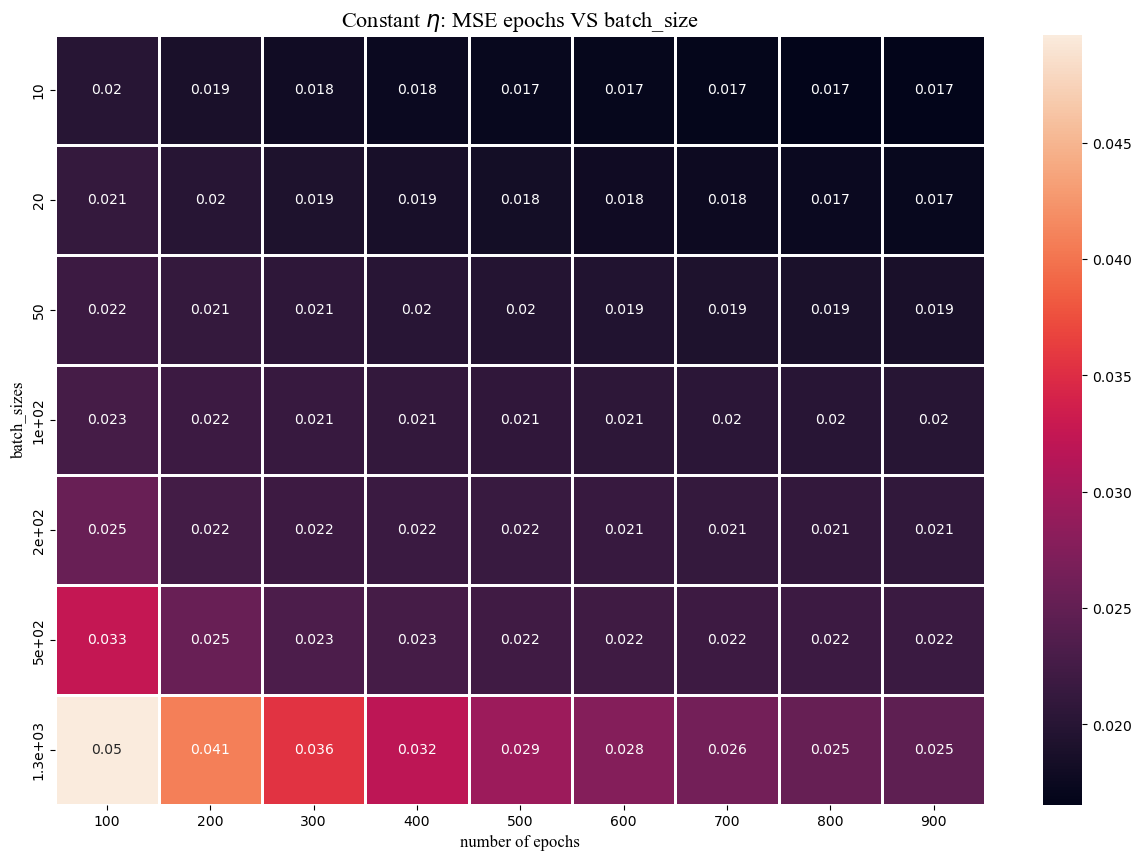

In [25]:
df_const = pd.DataFrame(mse_test_mom, index = formatted_batch_sizes, columns = n_epochs_array)
df_mom = pd.DataFrame(mse_test_mom, index = formatted_batch_sizes, columns = n_epochs_array)
df_adg = pd.DataFrame(mse_test_adg, index = formatted_batch_sizes, columns = n_epochs_array)
df_adgmom = pd.DataFrame(mse_test_adgmom, index = formatted_batch_sizes, columns = n_epochs_array)
df_adam = pd.DataFrame(mse_test_adam, index = formatted_batch_sizes, columns = n_epochs_array)
df_rms = pd.DataFrame(mse_test_rms, index = formatted_batch_sizes, columns = n_epochs_array)

fig, ax = plt.subplots(figsize=(15,10))   
sns.heatmap(df_const,annot =True, linewidths=.8, ax=ax,fmt='.2g')
ax.set_xlabel('number of epochs',fontdict={'fontfamily': 'Times new roman'}, fontsize=12)
ax.set_ylabel('batch_sizes',fontdict={'fontfamily': 'Times new roman'}, fontsize=12)
ax.set_title('Constant $\eta$: MSE epochs VS batch_size',fontdict={'fontfamily': 'Times new roman'}, fontsize=16)
fig.savefig('batch_size_const_sized')

fig, ax = plt.subplots(figsize=(15,10))   
sns.heatmap(df_mom,annot =True, linewidths=.8, ax=ax,fmt='.2g')
ax.set_xlabel('epochs')
ax.set_ylabel('batch_sizes')
ax.set_title('Mom: MSE epochs VS batch_size')
fig.savefig('batch_size_mom')

fig, ax = plt.subplots(figsize=(15,10))   
sns.heatmap(df_adg,annot =True, linewidths=.8, ax=ax,fmt='.2g')
ax.set_xlabel('epochs')
ax.set_ylabel('batch_sizes')
ax.set_title('Adagrad: MSE epochs VS batch_size')
fig.savefig('batch_size_adagrad')


fig, ax = plt.subplots(figsize=(15,10))   
sns.heatmap(df_adgmom,annot =True, linewidths=.8, ax=ax,fmt='.2g')
ax.set_xlabel('epochs')
ax.set_ylabel('batch_sizes')
ax.set_title('Adagrad with mom: MSE epochs VS batch_size')
fig.savefig('batch_size_adamom')


fig, ax = plt.subplots(figsize=(15,10))   
sns.heatmap(df_adam,annot =True, linewidths=.8, ax=ax,fmt='.2g')
ax.set_xlabel('epochs')
ax.set_ylabel('batch_sizes')
ax.set_title('Adam: MSE epochs VS batch_size')
fig.savefig('batch_size_adam')


fig, ax = plt.subplots(figsize=(15,10))   
sns.heatmap(df_rms,annot =True, linewidths=.8, ax=ax,fmt='.2g')
ax.set_xlabel('epochs')
ax.set_ylabel('batch_sizes')
ax.set_title('RMSprop: MSE epochs VS batch_size')
fig.savefig('batch_size_rms')

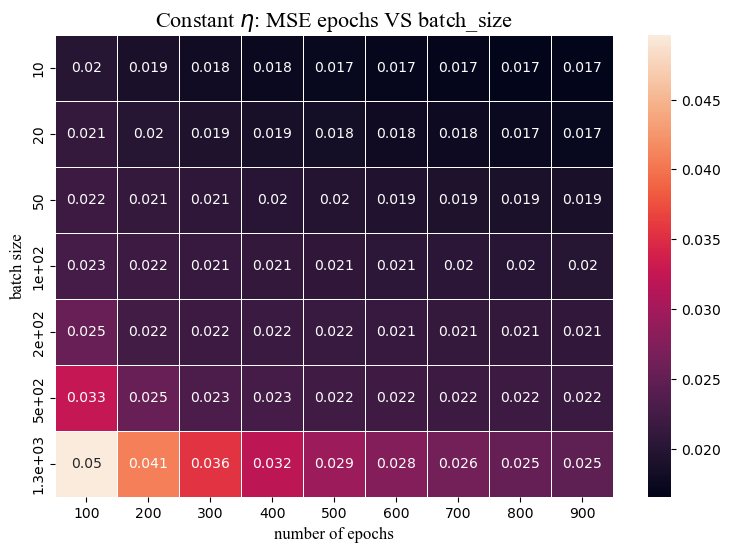

In [34]:

f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(df_const, annot=True, fmt=".2g", linewidths=.5, ax=ax)
ax.set_ylabel('batch size', fontdict={'fontfamily': 'Times New Roman'}, fontsize=12)
ax.set_xlabel('number of epochs', fontdict={'fontfamily': 'Times New Roman'}, fontsize=12)
plt.title("Constant $\eta$: MSE epochs VS batch_size",fontdict={'fontfamily': 'Times New Roman'}, fontsize=16)
plt.savefig("batch_size_const")
plt.show()

Large learning rate of 0.1 and a small batch of 10 leads to extremely high MSE. Overflow in with constant $\eta$ and momentum! Suggests that the interaction between learning rate and batch size is important to avoid overflow.
When batch size is small,the gradients are calculated from very few training datapoints. Since there is so little data used, numerical noise could potentially play a large role. Combining this with a large learning rate might lead to overflow?
Horrible results for Adagrad, Adagrad w/momentum, Adam and RMSprop. The learning rate is probably too high.

For a constant eta of 0.1, a batch size of 1600*0.8(the whole dataset) leads to the same MSE as the gradient descent MSE(without minibatches). This was expected. 

# Testing implication of batch size with $\eta = 0.01$ 


In [20]:
n_epochs_array = np.arange(100,1000,100) #increase step size to reduce running time
batch_sizes = np.array([10,20,50,100,200,500,len(X_train)])

mse_test_const = np.zeros((len(batch_sizes),len(n_epochs_array)))
mse_test_mom = np.zeros((len(batch_sizes),len(n_epochs_array)))
mse_test_adg = np.zeros((len(batch_sizes),len(n_epochs_array)))
mse_test_adgmom = np.zeros((len(batch_sizes),len(n_epochs_array)))
mse_test_rms = np.zeros((len(batch_sizes),len(n_epochs_array)))
mse_test_adam = np.zeros((len(batch_sizes),len(n_epochs_array)))

theta_j = 0
lr = 0
for i,batch_size in enumerate(batch_sizes):
    for j,n_epochs in enumerate(n_epochs_array):
        
        sgd_const = SGD(epochs = n_epochs, minibatch_size = batch_size,eta=0.01, momentum = 0.9,  decay=1e-4, schedule = 'Constant')
        theta_j, lr = sgd_const.fit(X_train, z_train)
        z_tilde= X_test @ theta_j
        mse_test_const[i,j] = mean_squared_error(z_test,z_tilde)
        
        sgd_mom = SGD(epochs = n_epochs, minibatch_size = batch_size,eta=0.01, momentum = 0.9,  decay=1e-4, schedule = 'Mom')
        theta_j, lr = sgd_mom.fit(X_train, z_train)
        z_tilde= X_test @ theta_j
        mse_test_mom[i,j] = mean_squared_error(z_test,z_tilde)
        
        sgd_adg = SGD(epochs = n_epochs, minibatch_size = batch_size, eta=0.01,momentum = 0.9, decay=1e-4, schedule = 'Adagrad')
        theta_j, lr = sgd_adg.fit(X_train, z_train)
        z_tilde= X_test @ theta_j
        mse_test_adg[i,j] = mean_squared_error(z_test,z_tilde)
        
        sgd_adgmom = SGD(epochs = n_epochs, minibatch_size = batch_size,eta=0.01 ,momentum = 0.9, decay=1e-4, schedule = 'Adagradmom')
        theta_j, lr = sgd_adgmom.fit(X_train, z_train)
        z_tilde= X_test @ theta_j
        mse_test_adgmom[i,j] = mean_squared_error(z_test,z_tilde)
        
        sgd_adam = SGD(epochs = n_epochs, minibatch_size = batch_size,eta=0.01 ,momentum = 0.9, decay=1e-4, schedule = 'Adam')
        theta_j, lr = sgd_adam.fit(X_train, z_train)
        z_tilde= X_test @ theta_j
        mse_test_adam[i,j] = mean_squared_error(z_test,z_tilde)
        
        sgd_rms = SGD(epochs = n_epochs, minibatch_size = batch_size,eta=0.01 ,momentum = 0.9, decay=1e-4, schedule = 'Rms')
        theta_j, lr = sgd_rms.fit(X_train, z_train)
        z_tilde= X_test @ theta_j
        mse_test_rms[i,j] = mean_squared_error(z_test,z_tilde)
        
formatted_batch_sizes = ["{:.2g}".format(i) for i in batch_sizes]


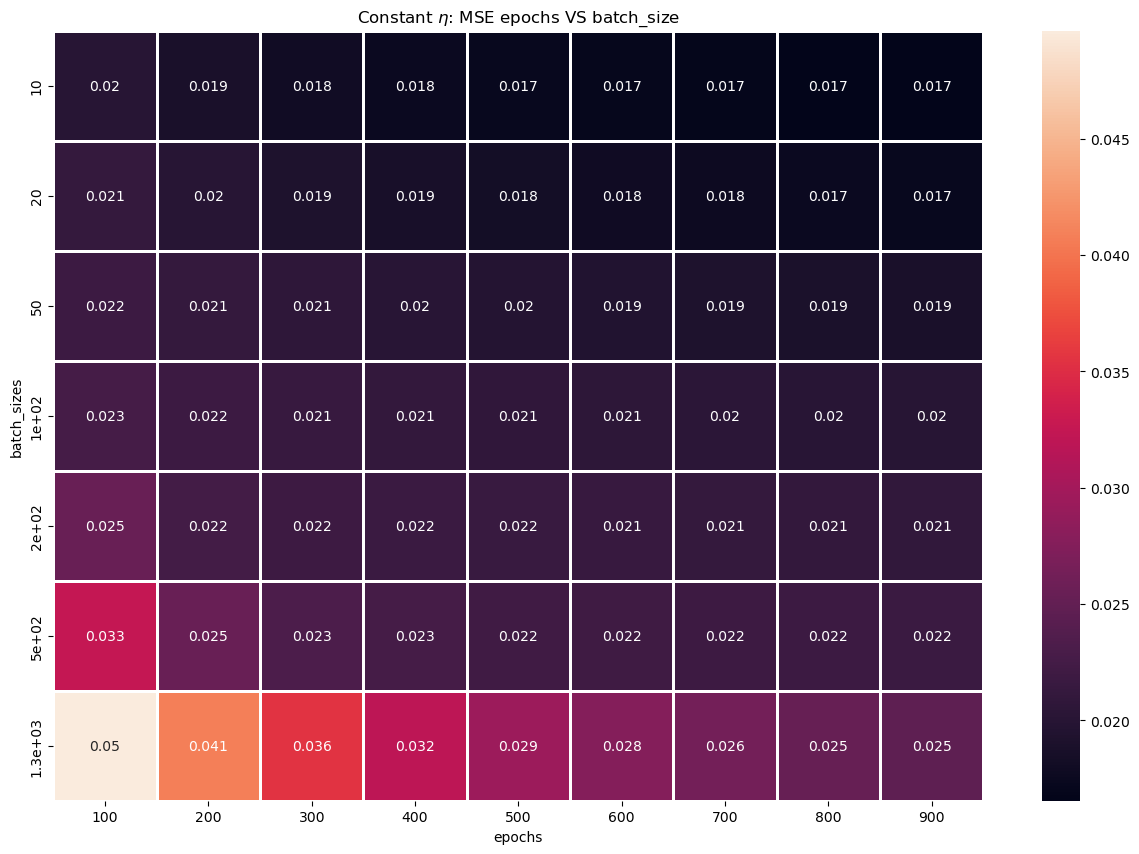

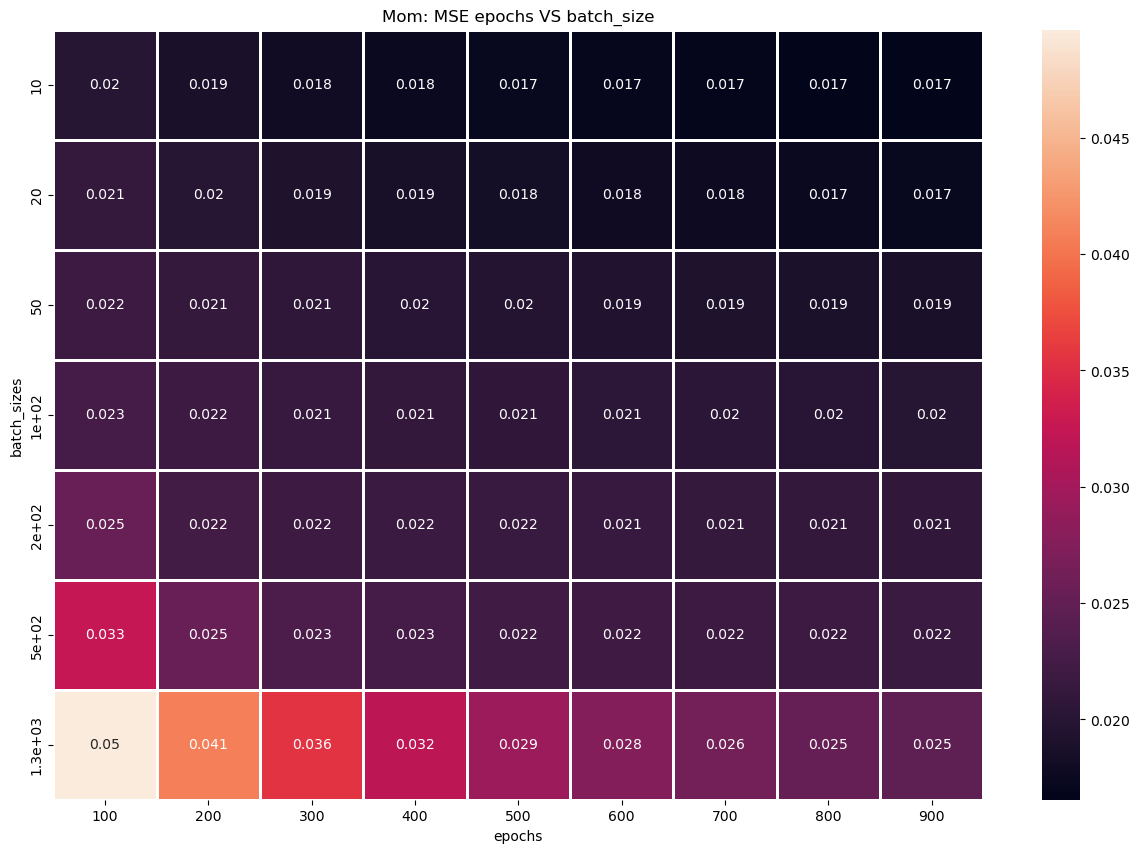

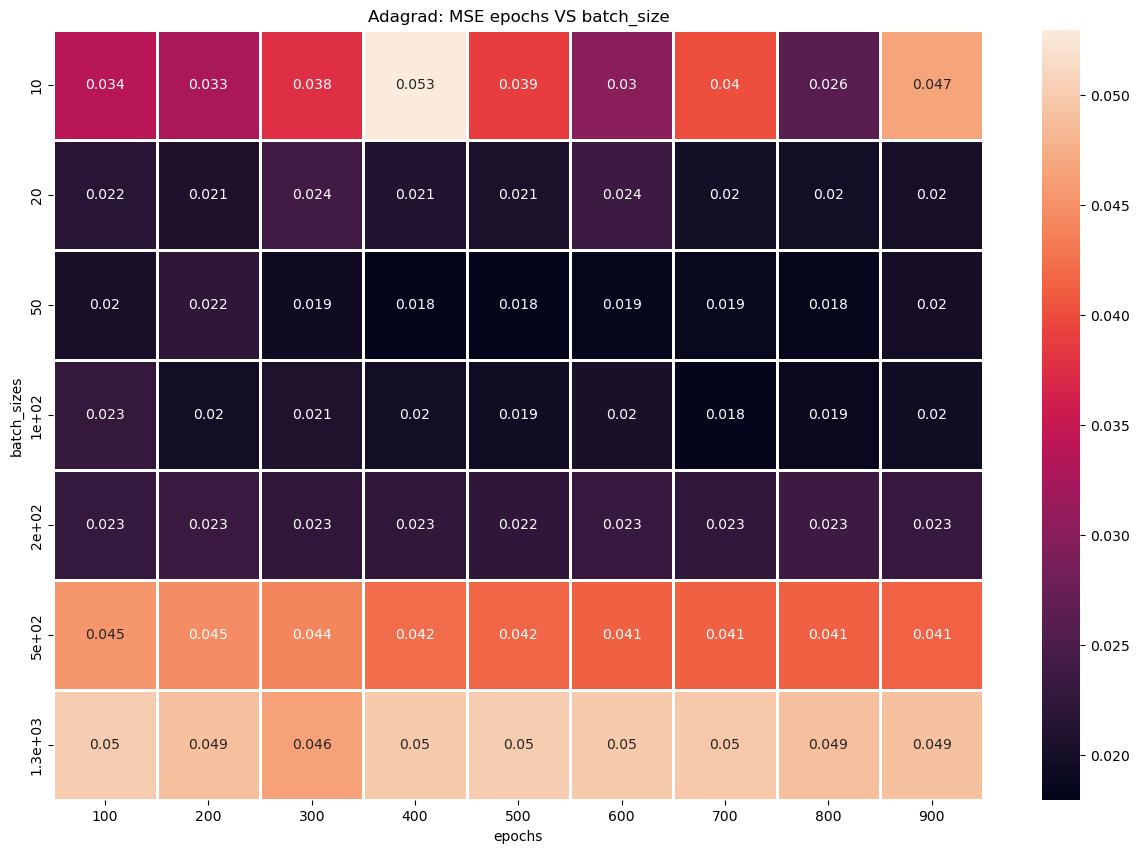

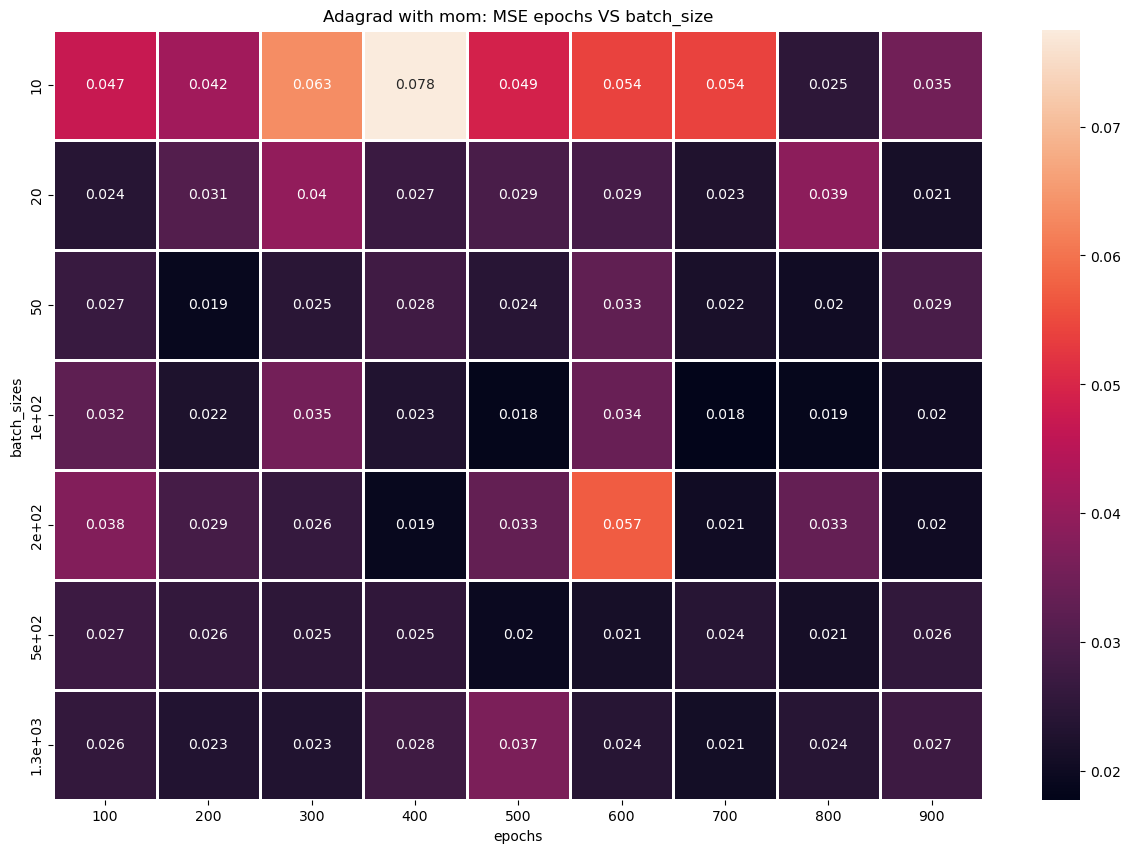

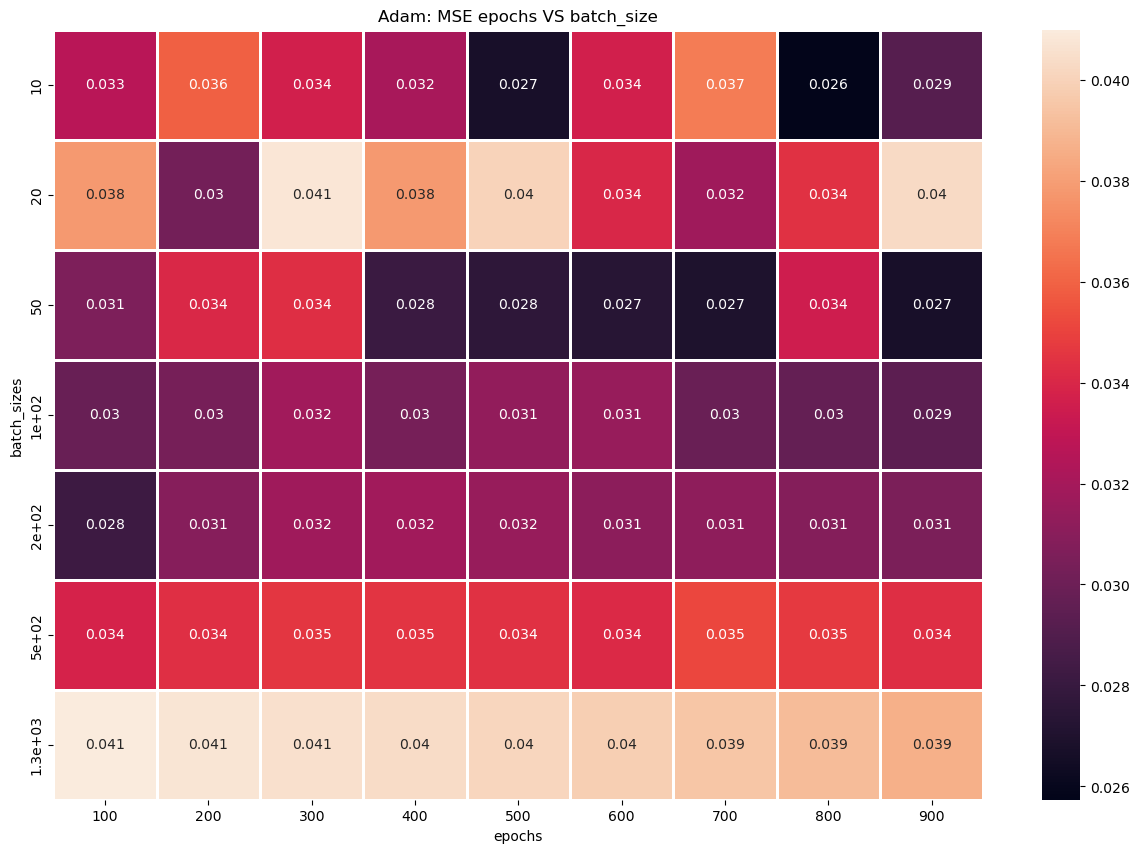

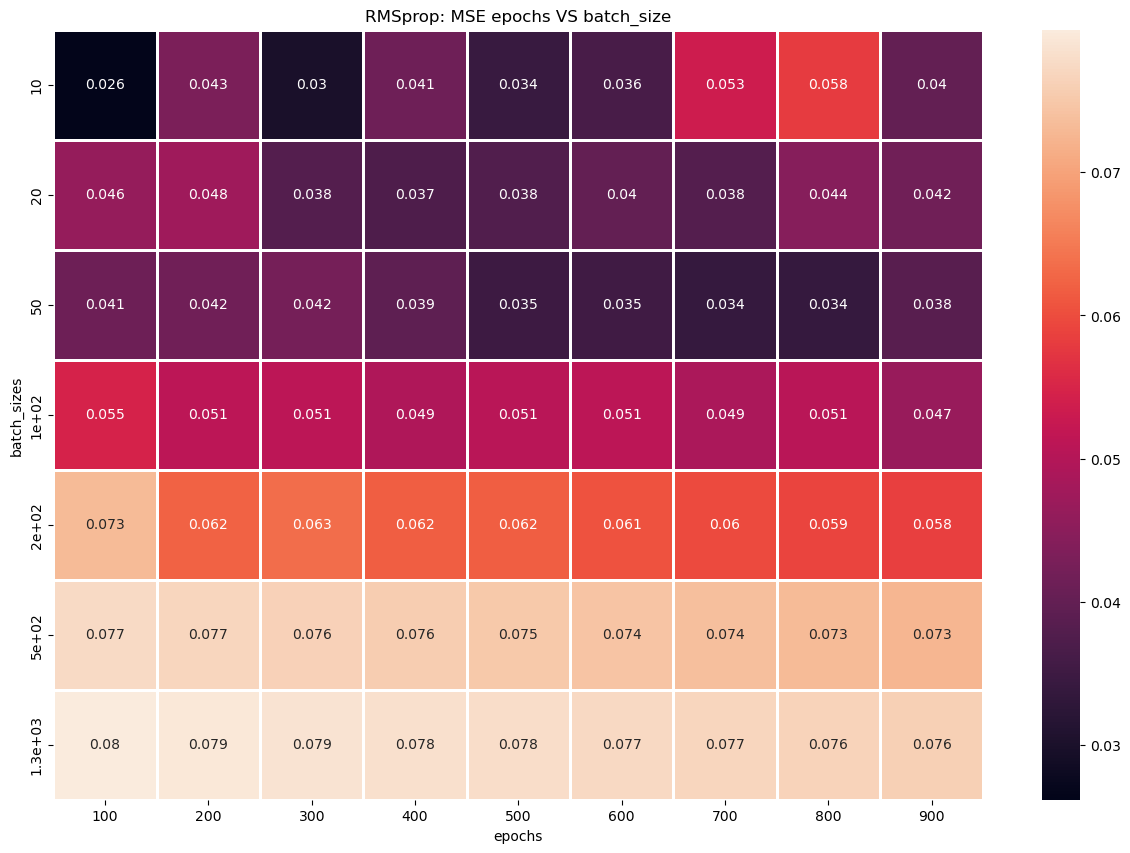

In [21]:
df_const = pd.DataFrame(mse_test_mom, index = formatted_batch_sizes, columns = n_epochs_array)
df_mom = pd.DataFrame(mse_test_mom, index = formatted_batch_sizes, columns = n_epochs_array)
df_adg = pd.DataFrame(mse_test_adg, index = formatted_batch_sizes, columns = n_epochs_array)
df_adgmom = pd.DataFrame(mse_test_adgmom, index = formatted_batch_sizes, columns = n_epochs_array)
df_adam = pd.DataFrame(mse_test_adam, index = formatted_batch_sizes, columns = n_epochs_array)
df_rms = pd.DataFrame(mse_test_rms, index = formatted_batch_sizes, columns = n_epochs_array)

fig, ax = plt.subplots(figsize=(15,10))   
sns.heatmap(df_const,annot =True, linewidths=.8, ax=ax,fmt='.2g')
ax.set_xlabel('epochs', )
ax.set_ylabel('batch_sizes')
ax.set_title('Constant $\eta$: MSE epochs VS batch_size')
fig.savefig('batch_size_const')

fig, ax = plt.subplots(figsize=(15,10))   
sns.heatmap(df_mom,annot =True, linewidths=.8, ax=ax,fmt='.2g')
ax.set_xlabel('epochs')
ax.set_ylabel('batch_sizes')
ax.set_title('Mom: MSE epochs VS batch_size')
fig.savefig('batch_size_mom')

fig, ax = plt.subplots(figsize=(15,10))   
sns.heatmap(df_adg,annot =True, linewidths=.8, ax=ax,fmt='.2g')
ax.set_xlabel('epochs')
ax.set_ylabel('batch_sizes')
ax.set_title('Adagrad: MSE epochs VS batch_size')
fig.savefig('batch_size_adagrad')


fig, ax = plt.subplots(figsize=(15,10))   
sns.heatmap(df_adgmom,annot =True, linewidths=.8, ax=ax,fmt='.2g')
ax.set_xlabel('epochs')
ax.set_ylabel('batch_sizes')
ax.set_title('Adagrad with mom: MSE epochs VS batch_size')
fig.savefig('batch_size_adamom')


fig, ax = plt.subplots(figsize=(15,10))   
sns.heatmap(df_adam,annot =True, linewidths=.8, ax=ax,fmt='.2g')
ax.set_xlabel('epochs')
ax.set_ylabel('batch_sizes')
ax.set_title('Adam: MSE epochs VS batch_size')
fig.savefig('batch_size_adam')


fig, ax = plt.subplots(figsize=(15,10))   
sns.heatmap(df_rms,annot =True, linewidths=.8, ax=ax,fmt='.2g')
ax.set_xlabel('epochs')
ax.set_ylabel('batch_sizes')
ax.set_title('RMSprop: MSE epochs VS batch_size')
fig.savefig('batch_size_rms')